# InSituPy demonstration - Build an `InSituData` object from scratch

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from datetime import datetime
from typing import Literal
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import geopandas as gpd
import dask.array as da
from shapely.geometry import Polygon
from insitupy import InSituData
from insitupy._core.dataclasses import CellData, BoundariesData, ImageData, AnnotationsData, RegionsData
import cv2
import zarr

## Let's start by generating main modalities and adding them into InSituData

Below you can find all functions used to generate the dummy code

In [3]:
# Function to generate a random H&E-like image
def generate_random_he_image(width, height):
    # Hematoxylin (blue-purple) and Eosin (pink) color ranges
    hematoxylin_color = np.array([102, 51, 153], dtype=np.uint8)  # Scaled to 0-255 range
    eosin_color = np.array([255, 204, 204], dtype=np.uint8)  # Scaled to 0-255 range
    # hematoxylin_color = np.array([0.4, 0.2, 0.6])
    # eosin_color = np.array([1.0, 0.8, 0.8])

    # random_image = np.random.rand(width, height, 3)
    random_image = np.random.randint(0, 256, (width, height, 3), dtype=np.uint8)
    he_image = random_image * hematoxylin_color // 255 + (255 - random_image) * eosin_color // 255
    # he_image = random_image * hematoxylin_color + (1 - random_image) * eosin_color

    return he_image

# Function to generate a random grayscale DAPI-like image
def generate_random_dapi_image(width, height):
    # DAPI (blue) color range in grayscale
    dapi_color = np.array([0.1, 0.1, 0.8])

    random_image = np.random.rand(width, height)
    dapi_image = random_image * dapi_color[2]  # Use the blue channel for grayscale

    return dapi_image

def generate_dummy_anndata(
    width,
    height,
    n_cells,
    num_genes = 400,
    pixel_size = 0.2125
    ):
    # In the next step we generate an `AnnData` object with respective spatial coordinates and a `Dask` Array with cellular boundaries for the respective cells.
    pixel_coordinates = np.random.rand(n_cells, 2) * [width, height]

    # Convert pixel coordinates to micrometers (1 pixel = 0.2125 micrometers)
    micrometer_coordinates = pixel_coordinates * pixel_size

    # Generate random gene expression counts matrix (n_cells x num_genes)
    gene_counts = np.random.poisson(lam=5, size=(n_cells, num_genes))

    # Create an AnnData object with gene expression counts and spatial coordinates
    adata = ad.AnnData(X=gene_counts)
    adata.obsm['spatial'] = micrometer_coordinates
    # Example observations (metadata)
    obs_data = {
        'cell_type': ['type1', 'type2'] * (n_cells // 2),  # Example cell types
        'batch': ['batch1'] * (n_cells // 2) + ['batch2'] * (n_cells // 2)  # Example batch information
    }

    # Add observations to the obs attribute
    adata.obs = adata.obs.assign(**obs_data)

    # add cell names
    adata.obs_names = [str(elem) for elem in range(1, n_cells+1)]
    return adata

def generate_cellular_boundaries_array(width, height, cell_positions, pixel_size, cell_size):
    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Create random roundish shapes
    for i, (x, y) in enumerate(cell_positions/pixel_size):
        num_points = np.random.randint(5, 15)  # Random number of points
        points = np.random.randint(-cell_size, cell_size, (num_points, 2)) + [x, y]
        hull = cv2.convexHull(points.astype(np.int32))
        cv2.fillConvexPoly(mask, hull, i+1)

    # Convert the NumPy array to a Dask array with chunks
    dask_array = da.from_array(mask, chunks=(50, 50))

    return dask_array

# Function to generate random polygons
def generate_random_geometries(num_polygons, x_size, y_size, pixel_size, mode: Literal["region", "annotation"]):
    polygons = []
    attempts = 0
    max_attempts = num_polygons * 10  # Limit the number of attempts to avoid infinite loop

    while len(polygons) < num_polygons and attempts < max_attempts:
        # Generate random center point
        center_x = np.random.uniform(0, x_size*pixel_size)
        center_y = np.random.uniform(0, y_size*pixel_size)

        # Generate random size for the polygon
        size = np.random.uniform(10, 20)

        # Create a square polygon around the center point
        polygon = Polygon([
            (center_x - size, center_y - size),
            (center_x + size, center_y - size),
            (center_x + size, center_y + size),
            (center_x - size, center_y + size)
        ])

        # Check if the new polygon intersects with any existing polygons
        if not any(polygon.intersects(existing_polygon) for existing_polygon in polygons):
            polygons.append(polygon)

        attempts += 1

    if mode == "annotation":
        # Create GeoDataFrame with random polygons
        result_df = gpd.GeoDataFrame(geometry=polygons)
        result_df["id"] = result_df.index
        result_df["name"] = ['annotation1'] * (num_polygons // 2) + ['annotation2'] * (num_polygons - (num_polygons // 2))

    if mode == "region":
        # Create GeoDataFrame with random polygons
        result_df = gpd.GeoDataFrame(geometry=polygons)
        result_df["id"] = result_df.index
        result_df["name"] = result_df.index

    return result_df

# Function to generate a random H&E-like image with a scale of 0-255 and uint8
def generate_random_he_image(height, width):
    # Hematoxylin (blue-purple) and Eosin (pink) color ranges in 0-255 scale
    hematoxylin_color = np.array([102, 51, 153])
    eosin_color = np.array([255, 204, 204])

    random_image = np.random.rand(height, width, 3)
    he_image = random_image * hematoxylin_color + (1 - random_image) * eosin_color

    # Convert the image to uint8
    he_image_uint8 = he_image.astype(np.uint8)

    return he_image_uint8
def generate_random_grayscale_image(height, width):
    # Generate a random grayscale image
    random_image = np.random.rand(height, width) * 255

    # Convert the image to uint8
    grayscale_image_uint8 = random_image.astype(np.uint8)

    return grayscale_image_uint8

## Now we use these functions to set up the dummy dataset step by step

First we specify the parameters for the dummy dataset

In [4]:
# parameters
pixel_size = 0.2125
height_um = 100 # µm
width_um = 100 # µm
height = int(height_um / pixel_size) # pixel width
width = int(width_um / pixel_size) # pixel width
n_cells = 10
num_genes = 20
cell_size = 50


### First, let's generate an H&E-like random numpy image

In [5]:
# Example usage
he_image = generate_random_he_image(height, width)
# Example usage
dapi_image = generate_random_grayscale_image(height, width)

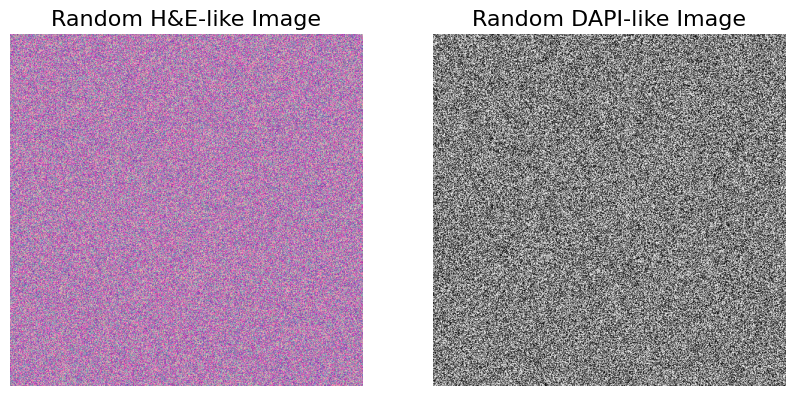

In [6]:
# Display the generated images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(he_image)
plt.title("Random H&E-like Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dapi_image, cmap='gray')
plt.title("Random DAPI-like Image")
plt.axis('off')

plt.show()

### In the next step we generate an `AnnData` object with respective spatial coordinates and a `Dask` Array with cellular boundaries for the respective cells.

In [7]:
# generate random anndata
adata = generate_dummy_anndata(width=width, height=height, n_cells=n_cells, num_genes=num_genes, pixel_size=pixel_size)

In [8]:
# generate random boundaries mask
cellular_boundaries_array = generate_cellular_boundaries_array(
    width=width, height=height,
    cell_positions=adata.obsm["spatial"],
    pixel_size=pixel_size, cell_size=cell_size)

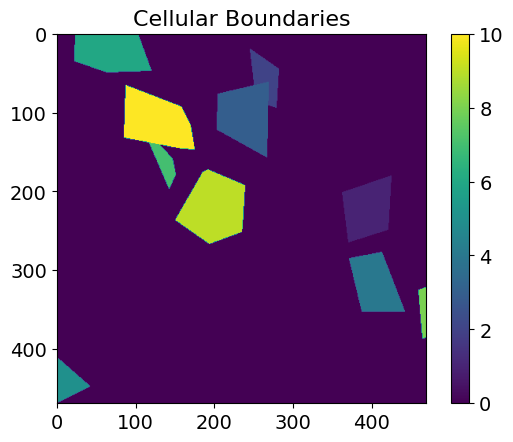

In [9]:
# Plot the boundaries
plt.imshow(cellular_boundaries_array, cmap='viridis')
plt.title("Cellular Boundaries")
plt.colorbar()
plt.show()

### Let's also generate example annotations and regions

In [10]:
# generate random annotations and regions
gdf_annotations = generate_random_geometries(num_polygons=5, x_size=height, y_size=width, pixel_size=pixel_size, mode="annotation")
gdf_regions = generate_random_geometries(num_polygons=5, x_size=height, y_size=width, pixel_size=pixel_size, mode="region")

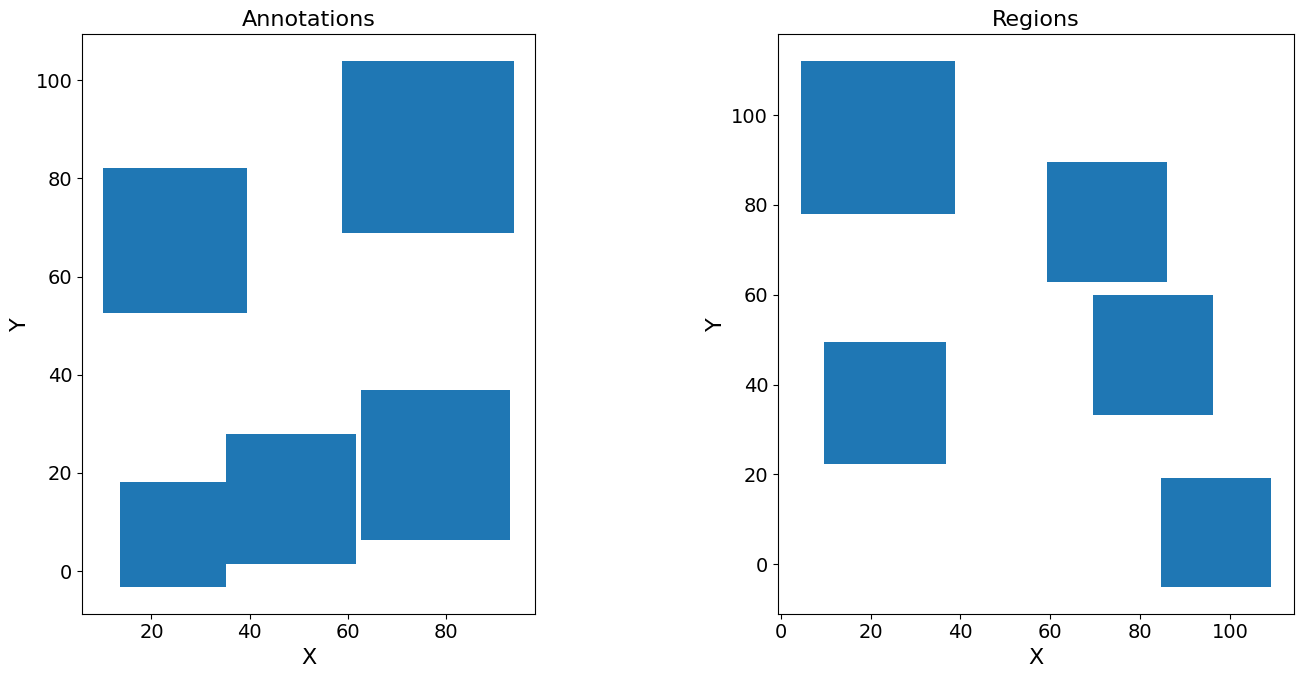

In [11]:
# Plot the annotations and regions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

gdf_annotations.plot(ax=axes[0])
axes[0].set_title("Annotations")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

gdf_regions.plot(ax=axes[1])
axes[1].set_title("Regions")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")

plt.tight_layout()
plt.show()

In [12]:
# Print the GeoDataFrame with random polygons
print(gdf_annotations.head())
print(gdf_regions.head())

                                            geometry  id         name
0  POLYGON ((35.232 1.353, 61.713 1.353, 61.713 2...   0  annotation1
1  POLYGON ((10.073 52.585, 39.555 52.585, 39.555...   1  annotation1
2  POLYGON ((58.869 68.922, 93.960 68.922, 93.960...   2  annotation2
3  POLYGON ((62.621 6.391, 93.035 6.391, 93.035 3...   3  annotation2
4  POLYGON ((13.667 -3.326, 35.102 -3.326, 35.102...   4  annotation2
                                            geometry  id  name
0  POLYGON ((59.354 62.821, 86.070 62.821, 86.070...   0     0
1  POLYGON ((4.582 78.010, 38.683 78.010, 38.683 ...   1     1
2  POLYGON ((9.551 22.287, 36.810 22.287, 36.810 ...   2     2
3  POLYGON ((84.686 -5.143, 109.036 -5.143, 109.0...   3     3
4  POLYGON ((69.593 33.280, 96.227 33.280, 96.227...   4     4


## Finally we create an `InSituData` object with all the modalities we have generated before

In [14]:
xd = InSituData(
    path=Path("dummy_path"),
    metadata={
        "method": "Xenium"
              },
    slide_id="slide",
    sample_id="sample_1",
    from_insitudata=False
    )

In [15]:
xd

InSituData
Method:		Xenium
Slide ID:	slide
Sample ID:	sample_1
Path:		dummy_path
Metadata file:	None

No modalities loaded.

Then we add the data in the correct format. A `CellData` object consists of (i) the transcriptomic data as `AnnData` object and (ii) the cellular and/or nuclear boundaries as `BoundariesData` object.

In [16]:
# set up the boundaries data object
bd = BoundariesData(cell_ids=adata.obs_names, seg_mask_value=None)
bd.add_boundaries(data={"cellular": cellular_boundaries_array}, pixel_size=pixel_size)

# set up the object for the cellular data based on the anndata object and the boundaries object
cd = CellData(matrix=adata, boundaries=bd)
xd.cells = cd

Images are stored in an `ImageData` object:

In [17]:

# add an empty ImageData object and add the generated images
xd.images = ImageData()
xd.images.add_image(image=he_image, name="H&E", axes="xyc", pixel_size=pixel_size, ome_meta={'PhysicalSizeX': pixel_size})
xd.images.add_image(image=dapi_image, name="nuclei", axes="xyc", pixel_size=pixel_size, ome_meta={'PhysicalSizeX': pixel_size})

... and annotations and regions as `AnnotationsData` or `RegionsData`, respectively.

In [18]:
# add the annotations and regions data
xd.annotations = AnnotationsData()
xd.annotations.add_data(gdf_annotations, key="example_annotation", scale_factor=1)

xd.regions = RegionsData()
xd.regions.add_data(gdf_regions, key="example_regions", scale_factor=1)

In [19]:
xd

InSituData
Method:		Xenium
Slide ID:	slide
Sample ID:	sample_1
Path:		dummy_path
Metadata file:	None
    ➤ images
       H&E:	(470, 470, 3)
       nuclei:	(470, 470)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 10 × 20
           obs: 'cell_type', 'batch'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 1 entry:
               cellular
    ➤ annotations
       example_annotation:	5 annotations, 2 classes ('annotation1','annotation2') 
    ➤ regions
       example_regions:	5 regions, 5 classes ('0','1','2','3','4') 

## Save the data into an `InSituPy` project

In [20]:
savepath = 'out/dummy_data'
xd.saveas(savepath, overwrite=True)

Saving data to out\dummy_data
Saved.


## Reload data

In [22]:
xd = InSituData.read(savepath)
xd.load_all()

No `transcripts` modality found.


## Visualize the data using the napari-viewer

In [23]:
xd.show()